Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: FILL IN YOUR NAMES HERE

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [5]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black
import matplotlib.pyplot as plt
import seaborn as sns


jupyter_black.load()

## Context
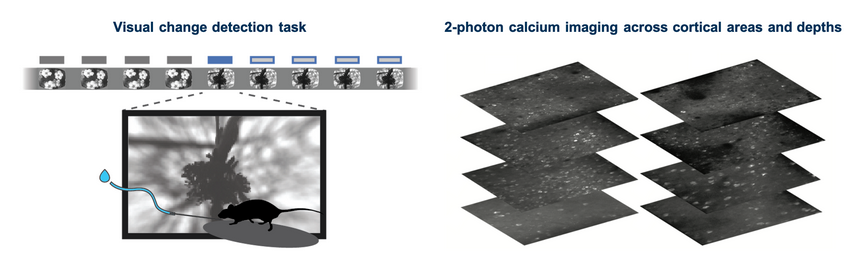

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

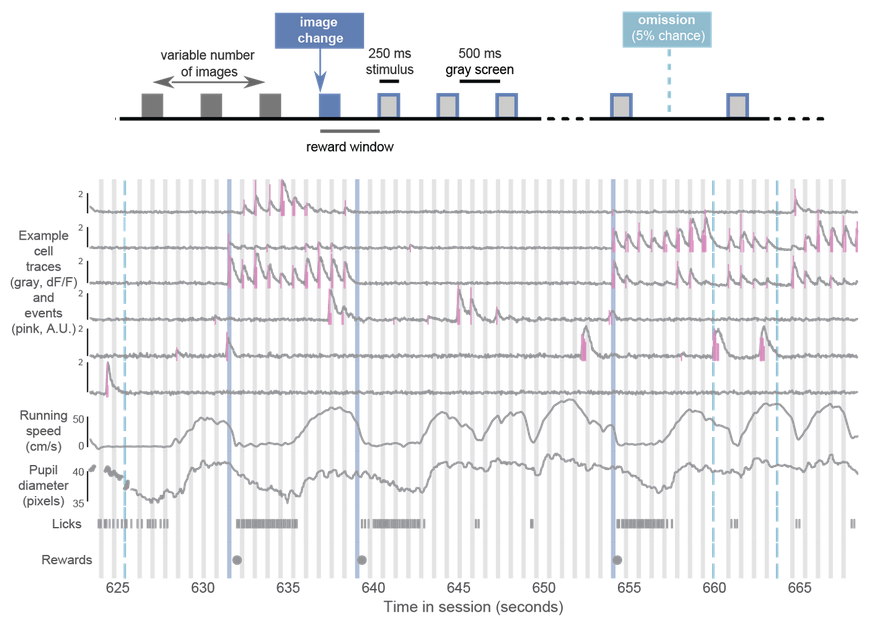

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [6]:
# load data
def load_data(path="./data"):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



## Question

**Is there spatial structure on the location of the receptive fields?** 

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

### Looking at the Data

firs, we look at the original documentation, to learn more about procedure and experimental set up of the experiment. through reverse image search of the attached pictures, we find that the data comes from allensswdb, and the documentation: https://allenswdb.github.io/physiology/ophys/visual-coding/vc2p-background.html

In [7]:
print_info(data)
print(data["stim_epoch_table"])
# filter for only the localy sparse stimulus data:
## side-note, first we have to rename the columns from the stim-epoch table, just to be tidy
data["stim_epoch_table"] = data["stim_epoch_table"].rename(
    columns={"start": "stimulus", "end": "start", "stimulus": "end"}
)
print(data["stim_epoch_table"])
# it is important to only do this (run the cell) once, since it changes the data directly.

[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)

                  start    end stimulus
0  locally_sparse_noise    737    22461
1           spontaneous  22611    31520
2     natural_movie_one  31521    40571
3  locally_sparse_noise  41476    63199
4     natural_movie_two  64105    73156
5           spontaneous  73306    82207
6  locally_sparse_noise  82208   105742
               stimulus  start     end
0  locally_sparse_noise    737   22461
1           spontaneous  22611   31520
2     natural_movie_one  31521   40571
3  locally_sparse_noise  41476   63199
4     natural_movie_two  64105   73

      frame  start    end
0         0    737    744
1         1    745    752
2         2    752    759
3         3    760    767
4         4    767    774
...     ...    ...    ...
2875   2875  22423  22430
2876   2876  22431  22438
2877   2877  22438  22446
2878   2878  22446  22453
2879   2879  22454  22461

[2880 rows x 3 columns]
      frame  start    end
2880   2880  41476  41483
2881   2881  41484  41491
2882   2882  41492  41499
2883   2883  41499  41506
2884   2884  41507  41514
...     ...    ...    ...
5755   5755  63162  63169
5756   5756  63170  63177
5757   5757  63177  63184
5758   5758  63185  63192
5759   5759  63192  63199

[2880 rows x 3 columns]
      frame   start     end
5760   5760   82208   82215
5761   5761   82215   82222
5762   5762   82223   82230
5763   5763   82230   82237
5764   5764   82238   82245
...     ...     ...     ...
8875   8875  105705  105712
8876   8876  105712  105719
8877   8877  105720  105727
8878   8878  105727  105734
8879   8879  10573

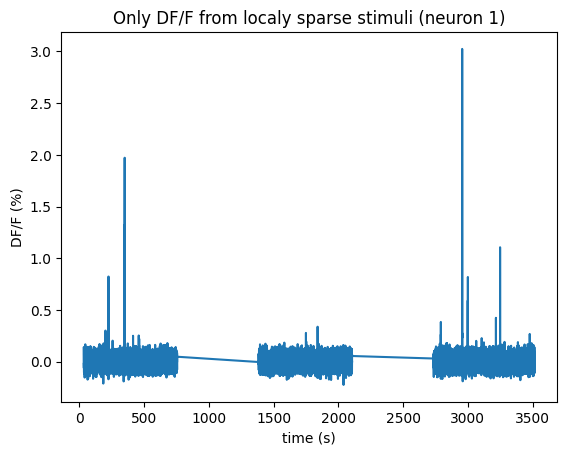

In [8]:
# now we can filter for the localy sparse stimulus:
# first get the correct stimuli, and extract their start- and end-times
times = data["stim_epoch_table"][
    data["stim_epoch_table"]["stimulus"] == "locally_sparse_noise"
][["start", "end"]].reset_index(drop=True)

# now get the data out of the df, put into smaller dfs, then concatenate those again.
new_data_accumulator_dfs = []
for idx, time in times.iterrows():
    start = time["start"]
    end = time["end"]

    new_data_accumulator_dfs.append(
        {
            "t": data["t"][start:end],
            "dff": data["dff"][:, start:end],
            "running_speed": data["running_speed"][:, start:end],
            "stim_table": data["stim_table"].loc[
                (data["stim_table"]["start"] >= start)
                & (data["stim_table"]["end"] <= end)
            ],
            "frame_number": np.arange(start, end),
        }
    )
    print(new_data_accumulator_dfs[-1]["stim_table"])

new_data_accumulator_dfs
new_data_dict_df = data.copy()
new_data_dict_df["t"] = np.concatenate([acc["t"] for acc in new_data_accumulator_dfs])
new_data_dict_df["dff"] = np.concatenate(
    [acc["dff"] for acc in new_data_accumulator_dfs], axis=-1
)
new_data_dict_df["running_speed"] = np.concatenate(
    [acc["running_speed"] for acc in new_data_accumulator_dfs], axis=-1
)
new_data_dict_df["stim_table"] = pd.concat(
    [acc["stim_table"] for acc in new_data_accumulator_dfs]
)
new_data_dict_df["frame_number"] = np.concatenate(
    [acc["frame_number"] for acc in new_data_accumulator_dfs]
)

# plot example spiketrain, for sanity check (scatter plot to have the sections not connected)
plt.plot(new_data_dict_df["t"], new_data_dict_df["dff"][0])
plt.ylabel("DF/F (%)")
plt.xlabel("time (s)")
plt.title("Only DF/F from localy sparse stimuli (neuron 1)")
plt.show()

#### Short explanation of the data and the importance for the question.

In [9]:
# t is the timestamp in seconds
print("max value:", data["t"].max())
print("min value:", data["t"].min())

# difference between timepoints in seconds
diff = np.unique(np.round((np.diff(data["t"])), 4))[0]
print(
    "differences between timepoints: ~",
    np.unique(np.round((np.diff(data["t"])), 4))[0],
)
print("sampling frequency: ~", np.round(1 / diff))

max value: 3524.5851
min value: 9.33015
differences between timepoints: ~ 0.0332
sampling frequency: ~ 30.0


In [10]:
# this is a list of stimuli, giving the frames at which they occur

new_data_dict_df["stim_table"].rename(
    columns={"frame": "stimulus_ID", "start": "start_frame", "end": "end_frame"},
    inplace=True,
)

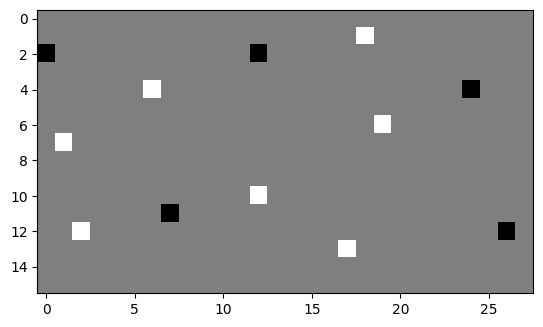

In [11]:
plt.imshow(data["stim"][0], cmap="grey")
plt.show()

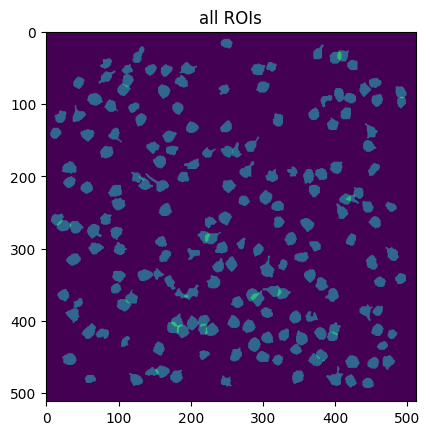

In [12]:
picture = np.zeros((512, 512))

for roi in new_data_dict_df["roi_masks"]:
    picture += roi

plt.imshow(picture)
plt.title("all ROIs")
plt.show()

In [13]:
print(new_data_dict_df["dff"].T.shape)
print(new_data_dict_df["t"].shape)

(66981, 189)
(66981,)


In [14]:
# put the stimuli frame number and the DFF per Neuron in one DF, to better handle them together, e.g. group by

# first put time and dff into a single df

time_df = pd.DataFrame(
    np.concatenate(
        [
            new_data_dict_df["dff"].T,
            new_data_dict_df["t"][:, np.newaxis],
            new_data_dict_df["frame_number"][:, np.newaxis],
        ],
        axis=-1,
    ),
    columns=[*np.arange(189), "time", "frame_number"],
)
# then add the stimulus frame number based on the stim_table
stim_table_df = new_data_dict_df["stim_table"]

# expand the stim table, to have as many rows as sampling points.
expanded_data = []

# Iterate through each row of the dataframe
for _, row in new_data_dict_df["stim_table"].iterrows():
    stim_ID = row["stimulus_ID"]
    start_value = row["start_frame"]
    end_value = row["end_frame"]

    # Generate the expanded range for the current frame
    for i in range(start_value, end_value + 1):

        expanded_data.append({"my_index": i, "stimulus_ID": stim_ID})

# Create the new dataframe from the expanded data
expanded_df = pd.DataFrame(expanded_data)
expanded_df.set_index("my_index", inplace=True)

# sometimes the end and start times of the frames overlap, in that case, we keep the latter stimuli, and delete the earlier.
expanded_df = expanded_df[~expanded_df.index.duplicated(keep="last")]

# drop the end times of the stimuli presentation sections, 3 values in total
expanded_df.drop([22461, 63199, 105742], inplace=True)

time_df["stim_ID"] = expanded_df.loc[time_df["frame_number"]].values

new_df = time_df.melt(
    id_vars=["time", "frame_number", "stim_ID"], var_name="cell_ID", value_name="dff"
)

In [15]:
new_df

,time,frame_number,stim_ID,cell_ID,dff
0,33.77772,737.0,0,0,-0.020660
1,33.81089,738.0,0,0,-0.048046
2,33.84406,739.0,0,0,0.051588
3,33.87724,740.0,0,0,0.053623
4,33.91041,741.0,0,0,0.142355
...,...,...,...,...,...
12659404,3516.95505,105737.0,8879,188,0.075955
12659405,3516.98822,105738.0,8879,188,0.068971
12659406,3517.02139,105739.0,8879,188,0.102139
12659407,3517.05457,105740.0,8879,188,-0.015119


In [16]:
# separate data into white and black pixels, to get on and off cells
stimuli = data["stim"]
grey_value = 127
black_value = 0
white_value = 255

# Create two new arrays initialized to the grey background
black_stimuli = np.full_like(stimuli, grey_value)
white_stimuli = np.full_like(stimuli, grey_value)

# Replace values in the black_stimuli where the original is black
black_stimuli[stimuli == black_value] = black_value

# Replace values in the white_stimuli where the original is white
white_stimuli[stimuli == white_value] = white_value

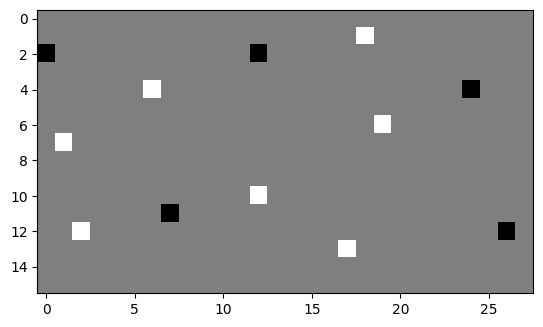

In [17]:
plt.imshow(data["stim"][0], cmap="grey")
plt.show()

In [22]:
df = new_df

## 2. Spike inference

####  step 1. OASIS algorithm implementation

In [361]:
from oasis.functions import deconvolve

# Load your dataframe (assuming it's saved as a CSV for this example)
df = new_df

# Get unique cell IDs
cell_ids = df["cell_ID"].unique()

# Dictionary to store the inferred spikes
inferred_spikes = {}

# Loop through each cell
for cell_id in cell_ids:
    # progress print
    print(f"currently processing cell: {cell_id}", end="\r")

    # Select the data for the current cell
    cell_data = df[df["cell_ID"] == cell_id]

    # Extract the 'dff' values
    dff = cell_data["dff"].values

    # Apply the OASIS deconvolution algorithm
    sp, c, b, g, lam = deconvolve(dff, penalty=1)

    # Store the results in the dictionary
    inferred_spikes[cell_id] = sp

    # also store it in the original dataframe
    df.loc[df["cell_ID"] == cell_id, "inferred_spikes"] = sp

# Convert the inferred spikes dictionary to a DataFrame for further analysis
inferred_spikes_df = pd.DataFrame.from_dict(inferred_spikes, orient="index").transpose()

# Save the inferred spikes to a CSV file
inferred_spikes_df.to_csv("inferred_spikes.csv", index=False)

KeyboardInterrupt: 

In [17]:
inferred_spikes_df = pd.read_csv("inferred_spikes.csv")
inferred_spikes_df

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,187,188
0,0.000000,0.005116,0.000000,0.000000,0.071779,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.017050,0.029772,0.015367,0.000000,0.000000e+00,0.000000e+00,0.048599,0.000000,0.000000,0.000000
1,0.000000,0.004290,0.000000,0.000000,0.057106,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015614,0.027404,0.023763,0.000000,0.000000e+00,0.000000e+00,0.044074,0.000000,0.000000,0.000000
2,0.042378,0.019414,0.000000,0.000000,0.045433,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.014298,0.025225,0.021903,0.000000,0.000000e+00,0.000000e+00,0.039970,0.000000,0.015209,0.000000
3,0.039095,0.016280,0.015806,0.000000,0.036146,0.043948,0.000000,0.000000,0.026506,0.000000,...,0.013094,0.023219,0.020189,0.000000,1.091182e-02,0.000000e+00,0.036248,0.000000,0.058194,0.055970
4,0.036066,0.013651,0.014058,0.091925,0.045415,0.039042,0.000999,0.061681,0.136599,0.030938,...,0.038844,0.021372,0.018609,0.000000,9.040513e-03,0.000000e+00,0.068401,0.083839,0.116629,0.067551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66976,0.000698,0.000016,0.034231,0.018781,0.005472,0.005805,0.001503,0.016936,0.000293,0.027166,...,0.096739,0.002339,0.009132,0.780707,4.945518e-07,1.657464e-06,0.011928,0.000238,0.000171,0.000927
66977,0.000644,0.000013,0.030446,0.016730,0.004353,0.005157,0.001402,0.015382,0.000253,0.023541,...,0.088591,0.002153,0.008417,0.933729,8.152880e-02,1.396297e-06,0.010818,0.000210,0.000161,0.000812
66978,0.000594,0.000011,0.027079,0.014903,0.003463,0.004581,0.001308,0.013971,0.000218,0.020401,...,0.081129,0.027895,0.007759,0.881177,6.754714e-02,1.176282e-06,0.009810,0.000186,0.000151,0.000711
66979,0.000548,0.000009,0.030991,0.013275,0.002755,0.004070,0.001221,0.012689,0.036356,0.017679,...,0.074295,0.122902,0.007151,0.831582,5.596325e-02,9.909345e-07,0.008897,0.000164,0.000143,0.000622


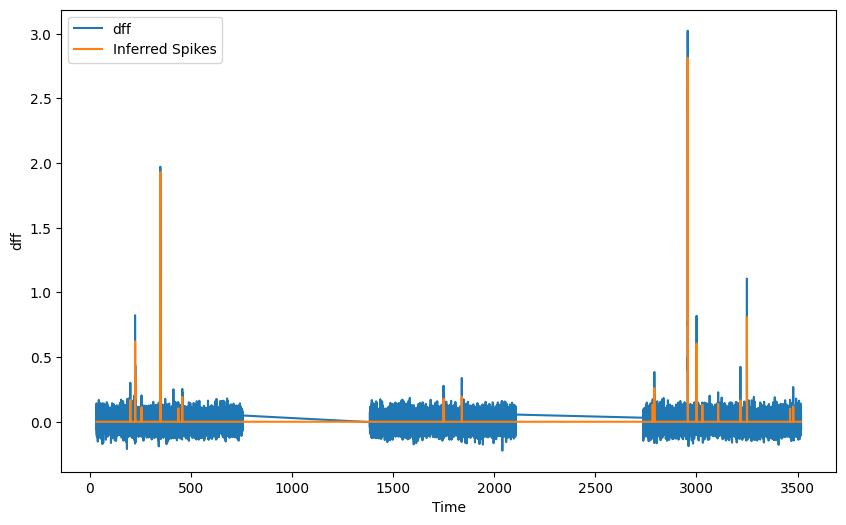

In [18]:
# Plot the results for a specific cell
# cell_id_to_plot = cell_ids[0]
# plot only the examplary results
cell_id_to_plot = 0

plt.figure(figsize=(10, 6))
plt.plot(
    df[df["cell_ID"] == cell_id_to_plot]["time"],
    df[df["cell_ID"] == cell_id_to_plot]["dff"],
    label="dff",
)
flattend_spikes = np.array([inferred_spikes[id] for id in cell_ids])
flattend_spikes[flattend_spikes <= 0.1] = 0

plt.plot(
    df[df["cell_ID"] == cell_id_to_plot]["time"],
    flattend_spikes[cell_id_to_plot],
    label="Inferred Spikes",
)
plt.xlabel("Time")
plt.ylabel("dff")
plt.legend()
plt.show()

### step 2. get spatial tuning
#### (1) Simple summation of spikes, (2) LNP model, (3) the RFest of Berenslab

In [55]:
# df = df_copy.copy()
df_copy = df.copy()

df.loc[df["inferred_spikes"] <= 0.10, "inferred_spikes"] = 0

In [31]:
# Get unique cell IDs and stimulus IDs
# cell_ids = df['cell_ID'].unique()
cell_ids = df["cell_ID"].unique()
stim_ids = df["stim_ID"].unique()
stim = white_stimuli
num_frames = 10


# Initialize a dictionary to store responses
spatial_tuning = {cell_id: np.zeros((16, 28)) for cell_id in cell_ids}
# Loop through each cell to calculate its response to each stimulus
for cell_id in cell_ids:
    print(f"currently processing cell: {cell_id}", end="\r")
    cell_data = df[df["cell_ID"] == cell_id]

    for i, row in cell_data[cell_data["inferred_spikes"] != 0].iterrows():
        frames = cell_data.loc[i - num_frames : i, "stim_ID"]

        stim_frames = stim[frames]  # Access the stimulus for the corresponding frame
        spikes = row["inferred_spikes"]  # Get the spikes value

        # Aggregate the response (here we're just summing)
        spatial_tuning[cell_id] += spikes * np.sum(stim_frames, axis=0) / num_frames

    spatial_tuning[cell_id] /= sum(cell_data["inferred_spikes"])

# Convert the spatial tuning dictionary to a DataFrame for easier analysis
spatial_tuning_df = pd.DataFrame(
    {cell_id: spatial_tuning[cell_id].flatten() for cell_id in cell_ids}
)

# Save the spatial tuning results to a CSV file
# spatial_tuning_df.to_csv('spatial_tuning.csv', index=False)

In [32]:
def znorm(X: np.ndarray):
    """needs input of shape n, xdim, ydim"""
    return  X.m(X -ean(axis=(1, 2))[:, np.newaxis, np.newaxis]) / X.std(axis=(1, 2))[
        :, np.newaxis, np.newaxis
    ]

In [33]:
spatial_tuning_np = np.array([spatial_tuning[id] for id in df["cell_ID"].unique()])
np.min(spatial_tuning_np)
spatial_tuning_np.shape
z_scored_spatial = znorm(spatial_tuning_np)
z_scored_spatial.shape
print(np.min(z_scored_spatial), np.max(z_scored_spatial))

-2.7346208545610127 11.150390907445814


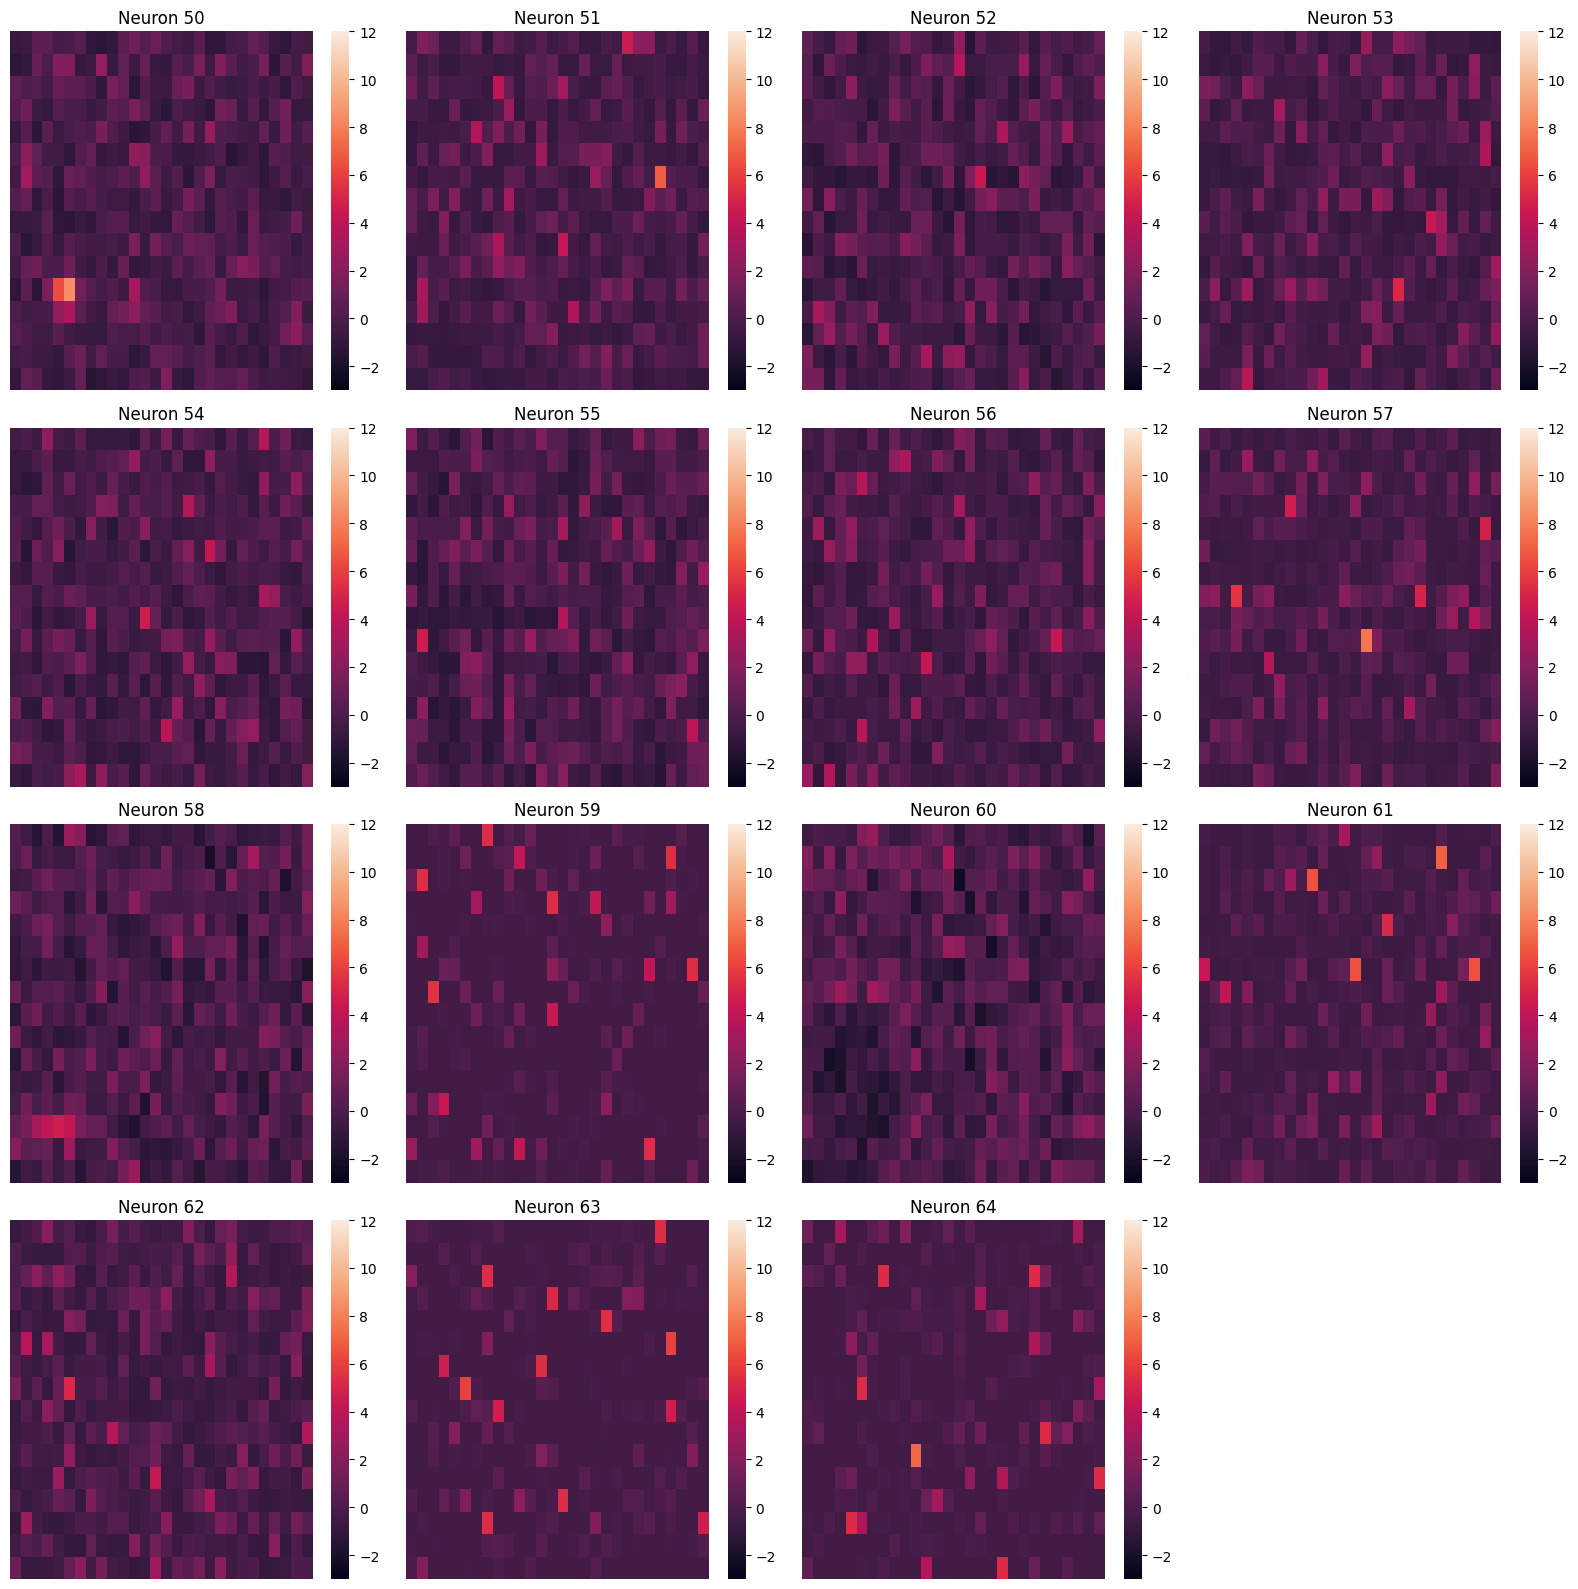

In [36]:
cell_ids = df["cell_ID"].unique()[50:65]

# Plot heatmaps for the spatial tuning of each neuron
num_neurons = len(cell_ids)
num_cols = 4  # Number of columns for subplots
num_rows = (num_neurons + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

for i, cell_id in enumerate(cell_ids):
    row, col = divmod(i, num_cols)
    ax = axes[row, col] if num_rows > 1 else axes[col]
    tuning_matrix = z_scored_spatial[cell_id]

    sns.heatmap(tuning_matrix, ax=ax, cbar=True, vmin=-3, vmax=12)
    ax.set_title(f"Neuron {cell_id}")
    ax.axis("off")

# Remove empty subplots
for j in range(i + 1, num_rows * num_cols):
    row, col = divmod(j, num_cols)
    fig.delaxes(axes[row, col] if num_rows > 1 else axes[col])

plt.tight_layout()
plt.show()

C:\Users\ralfk\AppData\Local\Temp\ipykernel_11372\184853312.py:23: RuntimeWarning: divide by zero encountered in log
  f = np.sum(-c * np.log(r) + np.log(factorial(c)) + r)
C:\Users\ralfk\AppData\Local\Temp\ipykernel_11372\184853312.py:23: RuntimeWarning: invalid value encountered in multiply
  f = np.sum(-c * np.log(r) + np.log(factorial(c)) + r)
C:\Users\ralfk\AppData\Local\Temp\ipykernel_11372\184853312.py:20: RuntimeWarning: overflow encountered in exp
  r = np.exp(wTs) * dt * R
C:\Users\ralfk\AppData\Local\Temp\ipykernel_11372\184853312.py:23: RuntimeWarning: invalid value encountered in add
  f = np.sum(-c * np.log(r) + np.log(factorial(c)) + r)
C:\Users\ralfk\AppData\Local\Temp\ipykernel_11372\184853312.py:31: RuntimeWarning: overflow encountered in exp
  r = np.exp(wTs) * dt * R
C:\Users\ralfk\AppData\Local\Temp\ipykernel_11372\184853312.py:34: RuntimeWarning: invalid value encountered in matmul
  df = (-c + r) @ s.T


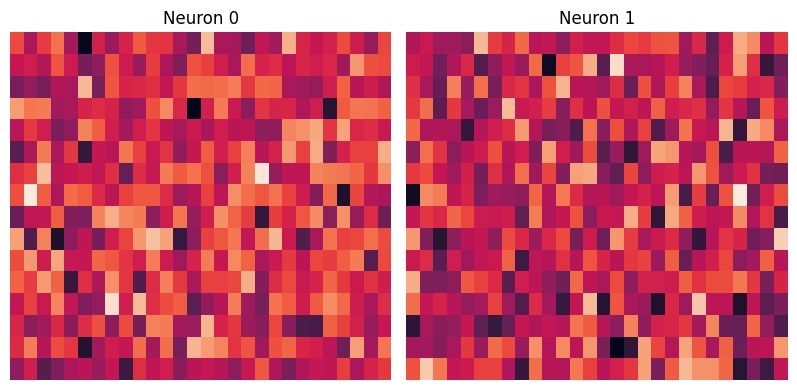

In [86]:
## Negative log likelihood model for spatial tuning assumption
from scipy.optimize import minimize
from scipy.special import factorial

# stim is a numpy array of shape (9000, 16, 28)

# Parameters
dt = 0.1
R = 50

# Extract unique cell IDs
# cell_ids = df['cell_ID'].unique()
cell_ids = [0, 1]


# Define the negative log-likelihood function
def negloglike_lnp(w, c, s, dt=0.1, R=50):
    w = w.reshape(-1, 1)  # column vector
    wTs = w.T @ s
    r = np.exp(wTs) * dt * R

    # Compute negative log-likelihood
    f = np.sum(-c * np.log(r) + np.log(factorial(c)) + r)
    return f


# Define the gradient of the negative log-likelihood function
def deriv_negloglike_lnp(w, c, s, dt=0.1, R=50):
    w = w.reshape(-1, 1)  # column vector
    wTs = w.T @ s
    r = np.exp(wTs) * dt * R

    # Compute gradient
    df = (-c + r) @ s.T
    return df.flatten()


# Fit the receptive field for each neuron
fitted_w = {}
for cell_id in cell_ids:
    # Extract data for the current cell
    cell_data = df[df["cell_ID"] == cell_id]
    spike_counts = inferred_spikes_df[cell_id].values
    frame_numbers = cell_data["stim_ID"].values.astype(int)

    # Construct stimulus matrix for the current cell
    stimuli = stim[frame_numbers].reshape(len(frame_numbers), -1).T  # (Dx * Dy, nT)

    # Initialize w (randomly)
    w_init = np.random.randn(16 * 28)
    w_init /= np.linalg.norm(w_init)  # normalize to ||w||=1

    # Optimize the receptive field
    result = minimize(
        negloglike_lnp,
        w_init,
        args=(spike_counts, stimuli, dt, R),
        jac=deriv_negloglike_lnp,
        method="L-BFGS-B",
    )

    # Store the fitted receptive field
    fitted_w[cell_id] = result.x.reshape(16, 28)

# plot results
num_neurons = len(cell_ids)
num_cols = 4  # Number of columns for subplots
num_rows = (num_neurons + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

for i, cell_id in enumerate(cell_ids):
    row, col = divmod(i, num_cols)
    ax = axes[row, col] if num_rows > 1 else axes[col]
    tuning_matrix = fitted_w[cell_id]

    sns.heatmap(tuning_matrix, ax=ax, cbar=False)
    ax.set_title(f"Neuron {cell_id}")
    ax.axis("off")

# Remove empty subplots
for j in range(i + 1, num_rows * num_cols):
    row, col = divmod(j, num_cols)
    fig.delaxes(axes[row, col] if num_rows > 1 else axes[col])

plt.tight_layout()
plt.show()

## 3. we also found this cool lab
https://github.com/berenslab/RFEst

They say it doesnt work on windows, but it does...

They have functions for all sorts of receptive field analysis. we try out some here. 

But first, we have to make our data fit into their functions

In [18]:
import rfest

In [19]:
# to get a feel for what shape the data is supposed to be in. we will basically now follow some steps from the tutorial notebook in https://github.com/huangziwei/notebooks_RFEst

example_data = rfest.utils.fetch_data(5)
example_data["stim"].shape

(Ran, et al. 2020) is already downloaded. To re-download the same file, please set `overwrite=False`.
Loading data (Ran, et al. 2020)...
Done.


(1500, 20, 15)

nice, we know that shape, no need to change our data then :)

In [20]:
def compute_STA(X, y, dims):
    "copied from https://github.com/huangziwei/notebooks_RFEst"
    if len(X.shape) == 1:
        X = X[:, None]

    if len(y.shape) == 1:
        y = y[:, None]

    n_spikes = np.sum(y)
    w_STA = X.T @ y / n_spikes

    return w_STA.reshape(dims)

In [24]:
stim = white_stimuli
num_frames = 10
# Group the DataFrame by cell_ID
grouped = df.groupby("cell_ID")

print("precomputing...", end="\r")
# Precompute the design matrix
stim_ids = df.loc[df["cell_ID"] == 0, "stim_ID"]
stims = stim[stim_ids]
Xdsgn = rfest.utils.build_design_matrix(stims, 10)

w_sta_3d_white = []
for cell_id, cell_df in grouped:
    print(f"currently processing cell: {cell_id}", end="\r")
    y = cell_df["dff"].values
    ygrad = np.gradient(
        y
    )  # Gradient is better correlated with firing rate, see the supplementary Fig. 3 of Ran, Huang et al. (2020) for details.

    w_sta_3d_white.append(compute_STA(Xdsgn, ygrad, [num_frames, *stims.shape[1:3]]))

w_sta_3d_white = np.array(w_sta_3d_white)

In [25]:
stim = black_stimuli
w_sta_3d_black = []
print("precomputing...", end="\r")
stims = stim[stim_ids]  # the stim_IDs are the same
Xdsgn = rfest.utils.build_design_matrix(stims, 10)

for cell_id, cell_df in grouped:
    print(f"currently processing cell: {cell_id}", end="\r")
    y = cell_df["dff"].values
    ygrad = np.gradient(
        y
    )  # Gradient is better correlated with firing rate, see the supplementary Fig. 3 of Ran, Huang et al. (2020) for details.

    w_sta_3d_black.append(compute_STA(Xdsgn, ygrad, [num_frames, *stims.shape[1:3]]))

w_sta_3d_black = np.array(w_sta_3d_black)

In [77]:
def znorm_3d(X: np.ndarray):
    """needs input of shape n, t, xdim, ydim"""
    return (X - X.mean(axis=(1, 2, 3))[:, np.newaxis, np.newaxis, np.newaxis]) / X.std(
        axis=(1, 2, 3)
    )[:, np.newaxis, np.newaxis, np.newaxis]


z_score_white = znorm_3d(w_sta_3d_white)
z_score_black = znorm_3d(w_sta_3d_black)

In [71]:
significant_neurons_black = z_score_black[
    np.any(np.abs(z_score_black) > 6, axis=(1, 2, 3))
]
significant_neurons_white = z_score_white[
    np.any(np.abs(z_score_white) > 6, axis=(1, 2, 3))
]

idx_black = np.where(np.any(np.abs(z_score_black) > 10, axis=(1, 2, 3)))
idx_white = np.where(np.any(np.abs(z_score_white) > 10, axis=(1, 2, 3)))

print(idx_black[0])
print(idx_white[0])

[ 20  60  83  89 114 144 150]
[ 32  43  58 112 125 182]


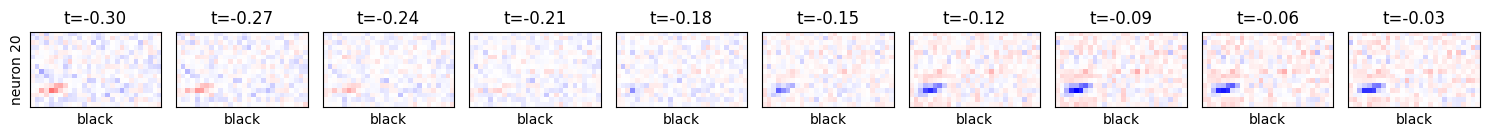

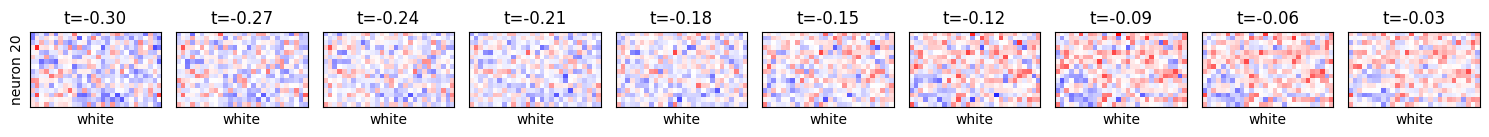

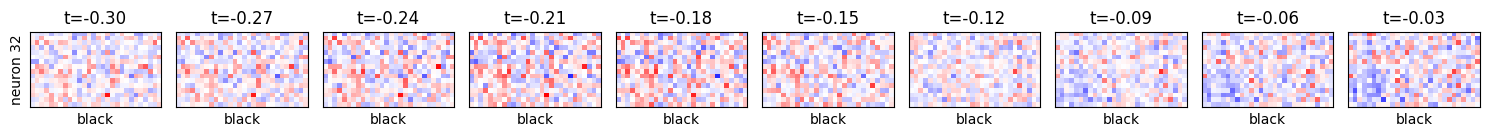

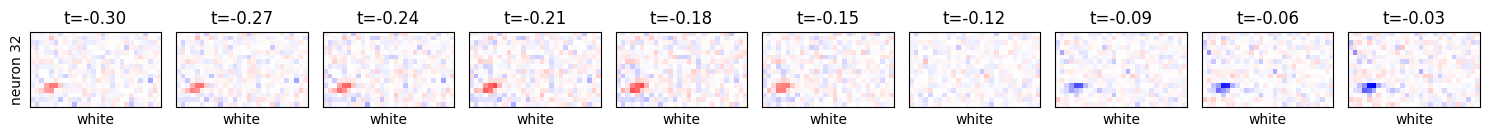

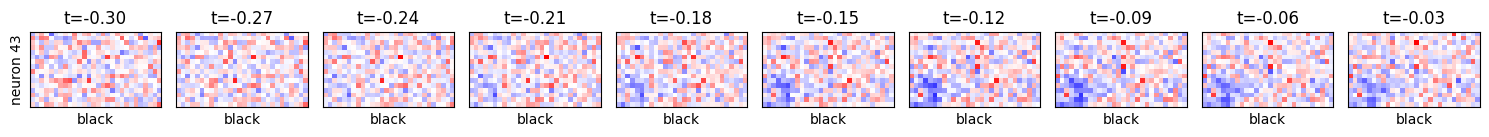

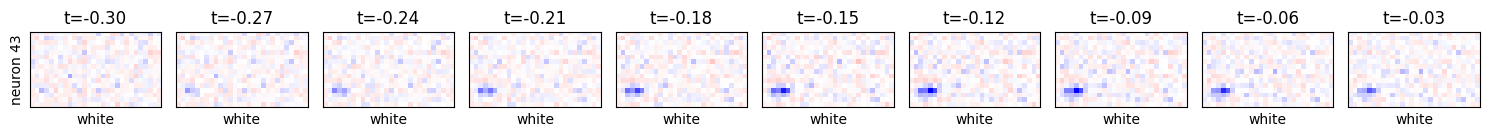

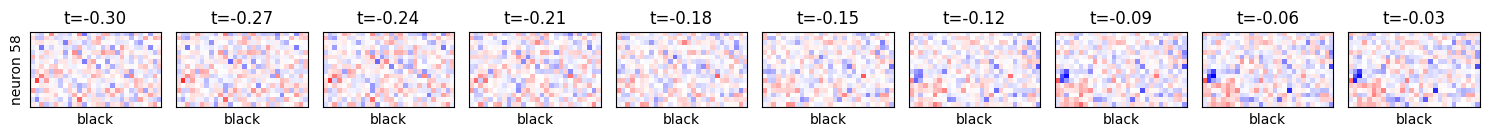

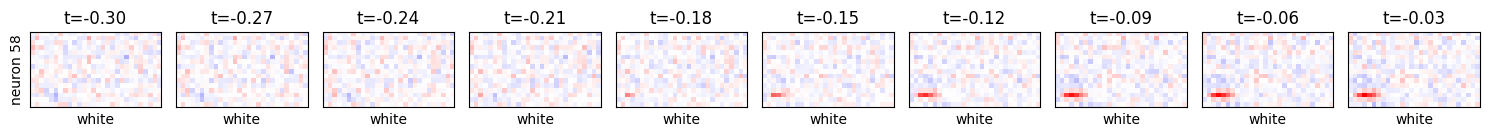

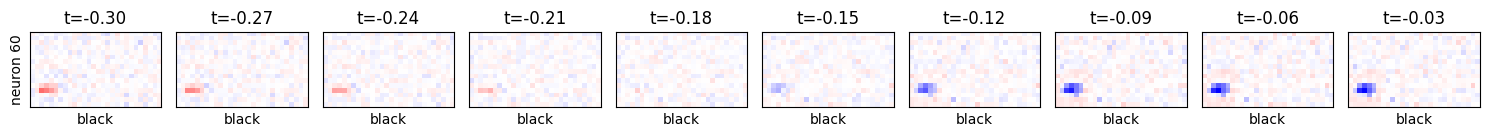

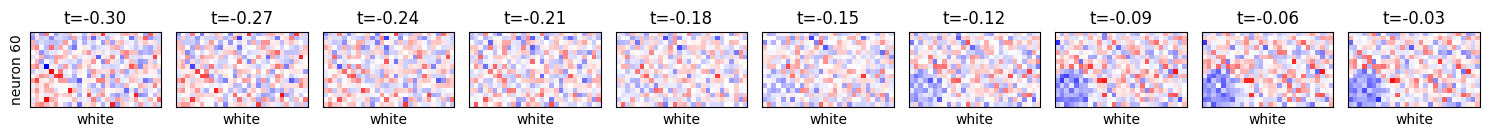

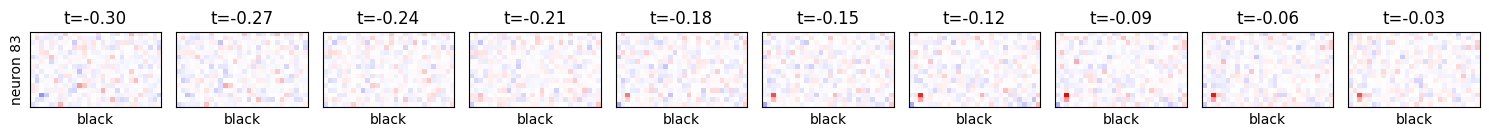

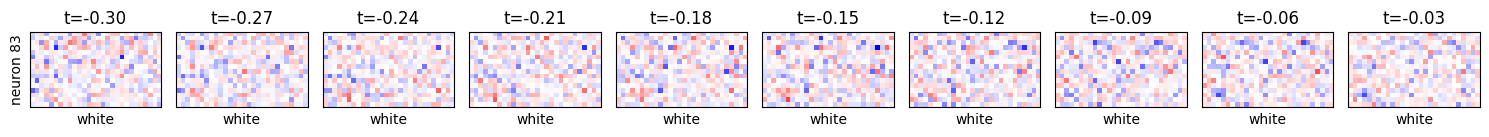

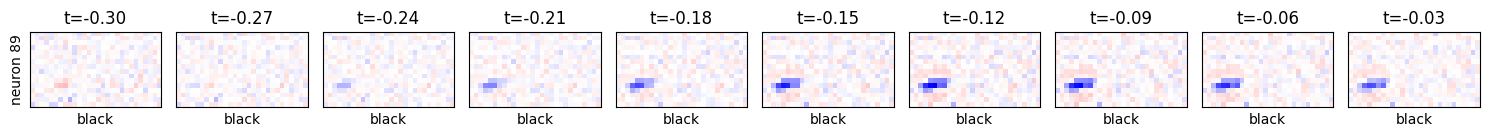

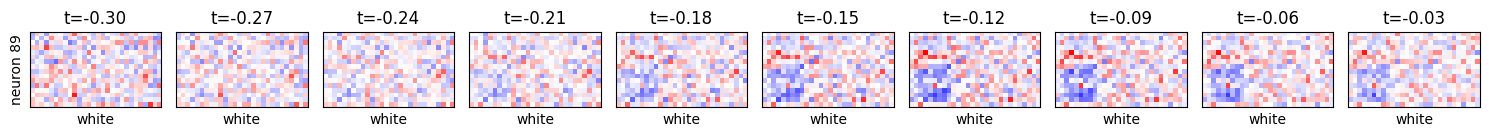

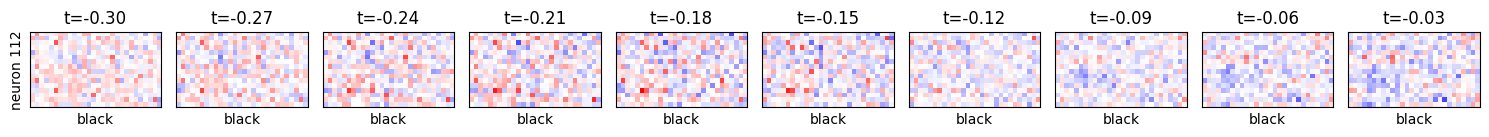

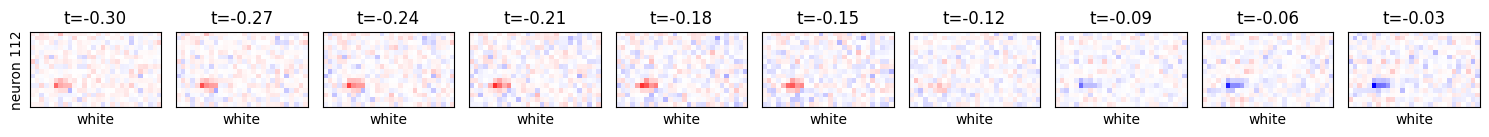

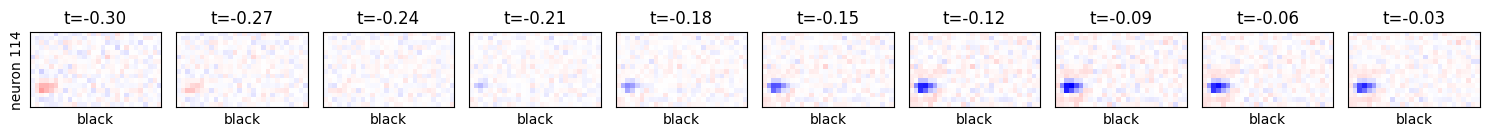

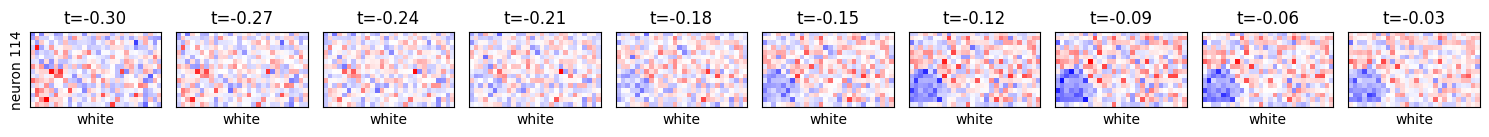

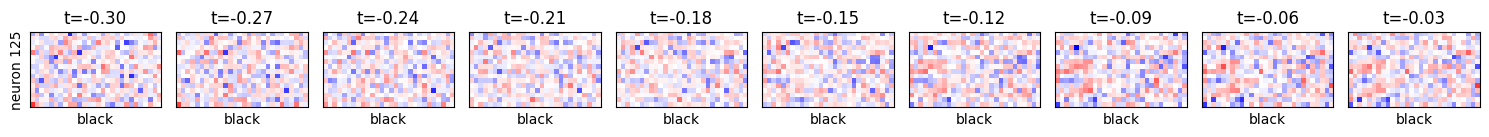

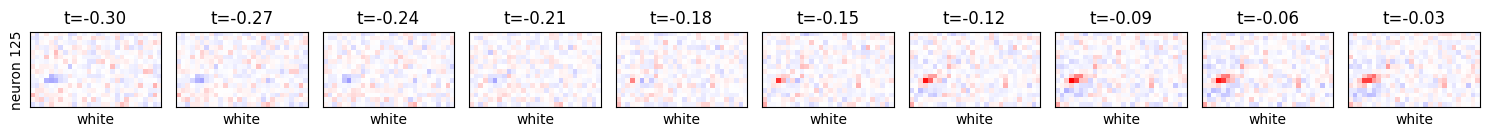

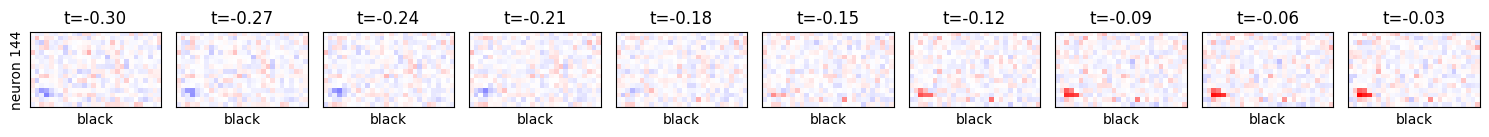

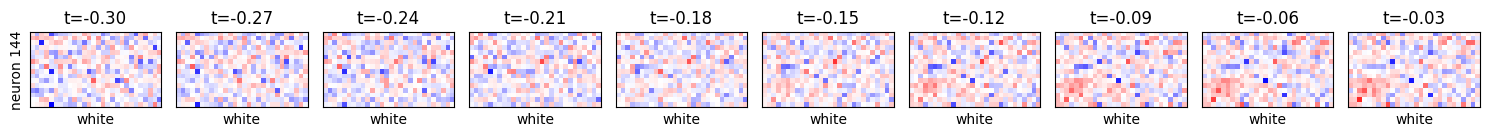

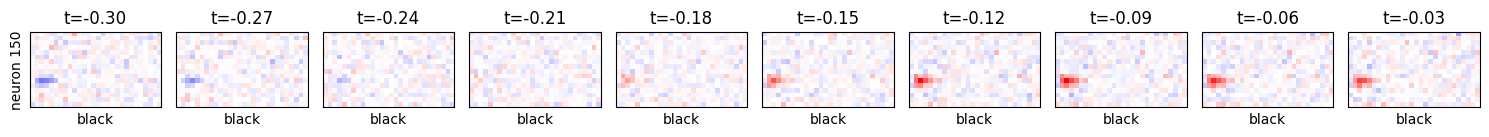

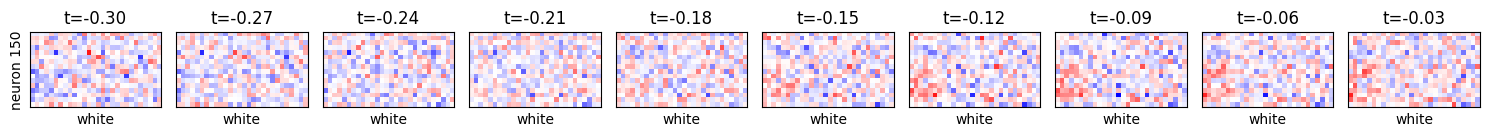

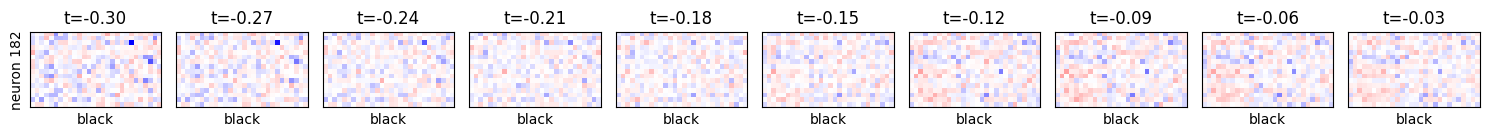

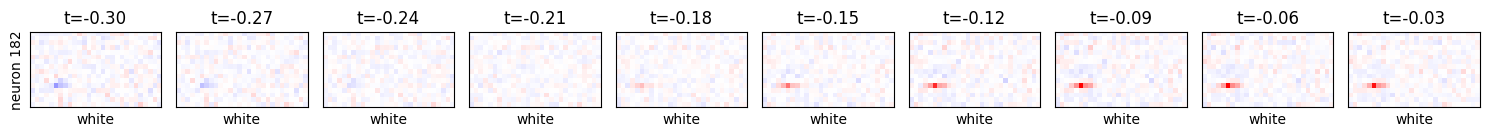

In [72]:
dt = 0.03
tt = np.arange(-dt * num_frames, dt, dt)

for cell_id in df["cell_ID"].unique():
    if not (cell_id in [*idx_black[0], *idx_white[0]]):
        continue

    for j, rfs in enumerate([z_score_black, z_score_white]):

        vmax = np.max([np.abs(rfs[cell_id].min()), rfs[cell_id].max()])

        fig, ax = plt.subplots(1, 10, figsize=(15, 3))
        for i in range(10):
            ax[i].imshow(rfs[cell_id][i], cmap=plt.cm.bwr, vmin=-vmax, vmax=vmax)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_title(f"t={tt[i]:.02f}")
            ax[i].set_xlabel(["black", "white"][j % 2])
            if i == 0:
                ax[i].set_ylabel(f"neuron {cell_id}")
        fig.tight_layout()
        plt.show()

now in smooth:

In [74]:
from scipy.ndimage import gaussian_filter

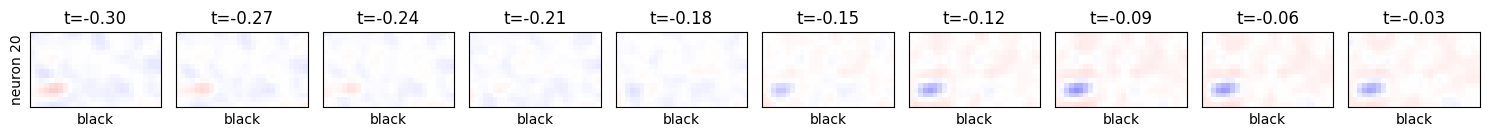

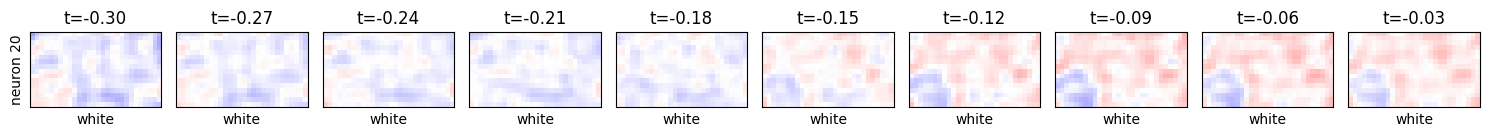

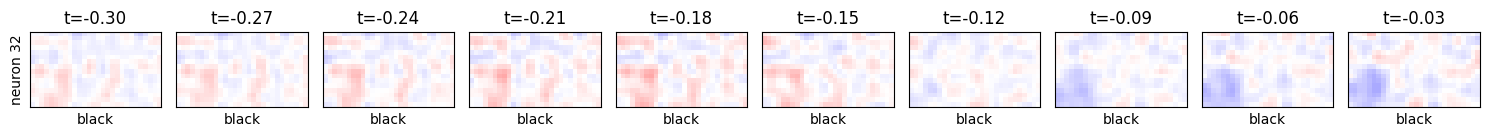

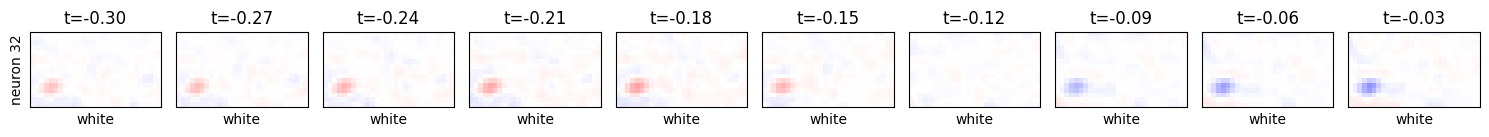

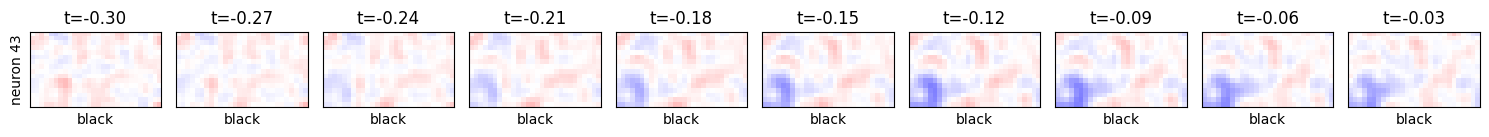

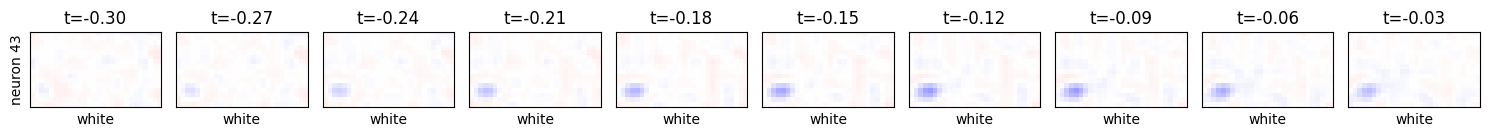

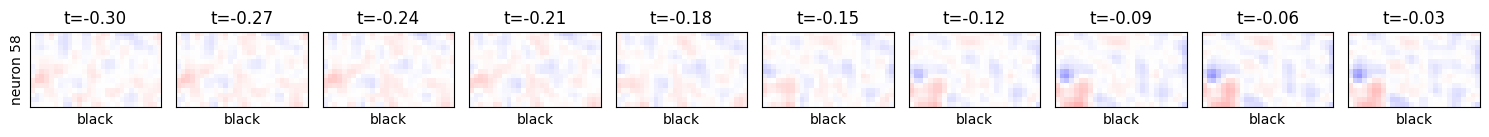

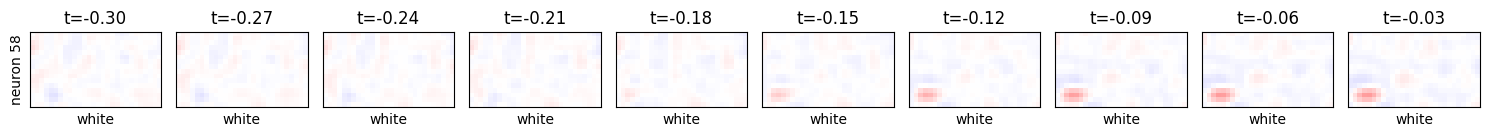

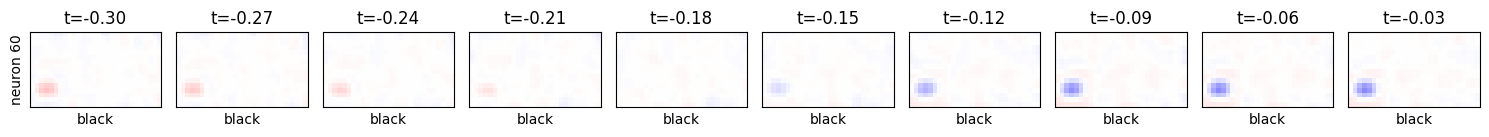

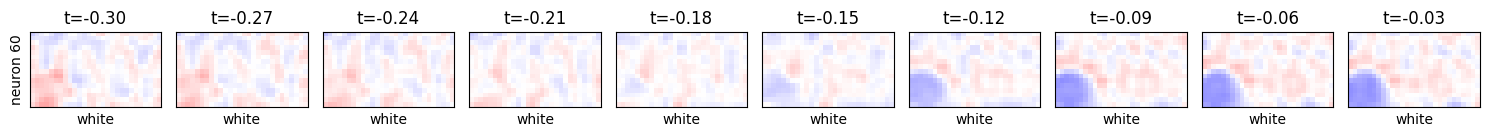

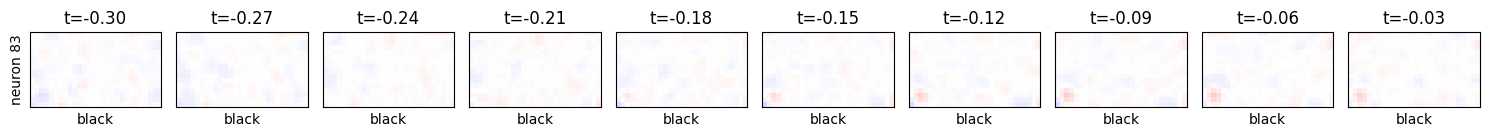

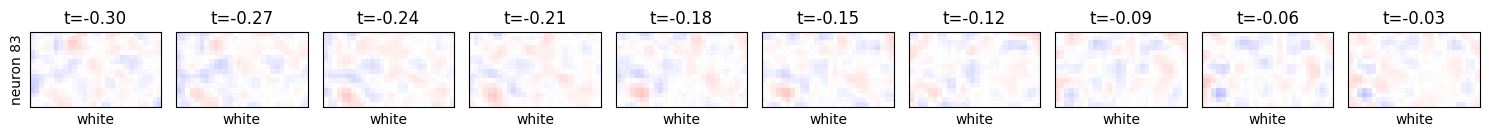

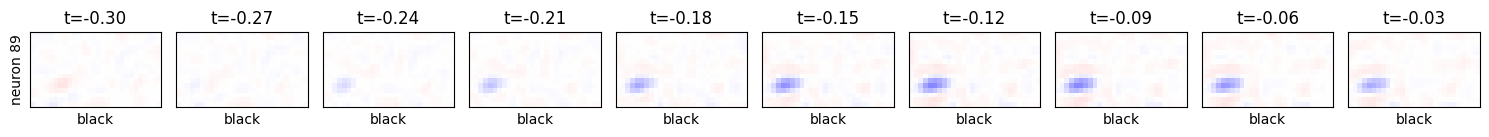

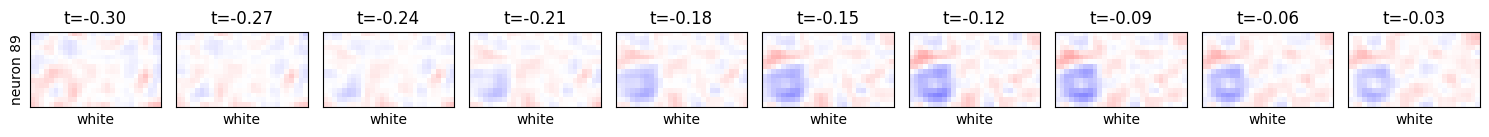

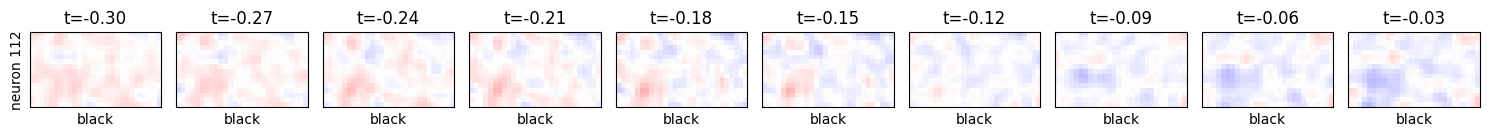

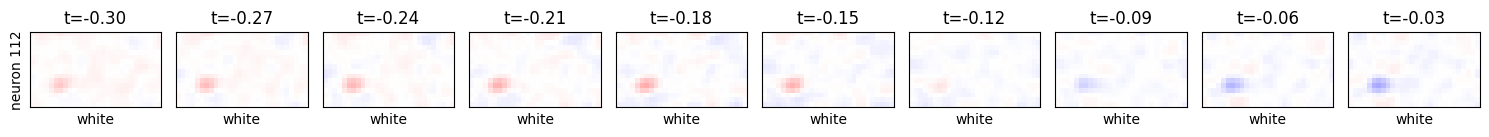

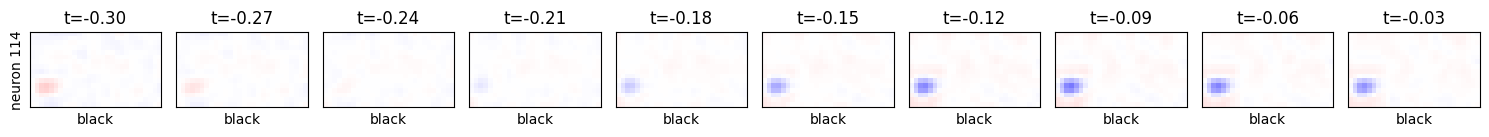

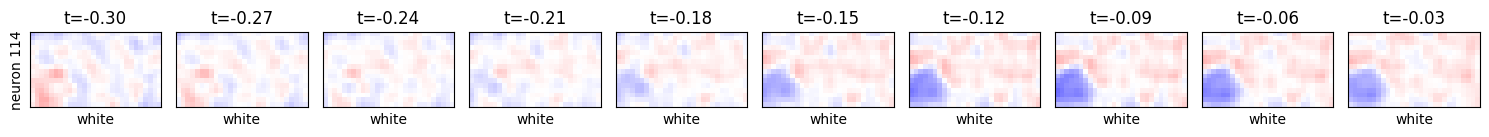

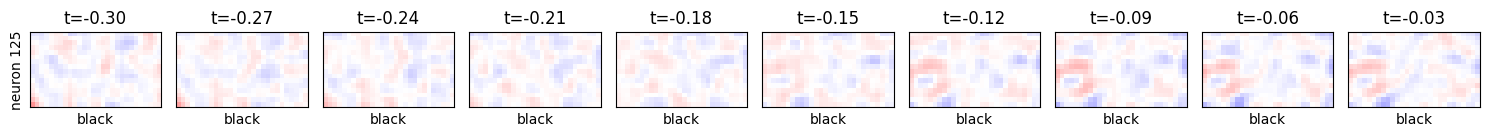

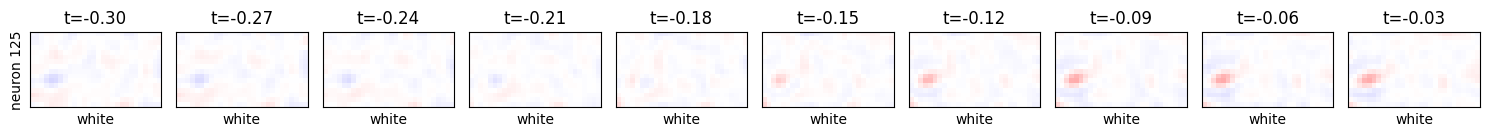

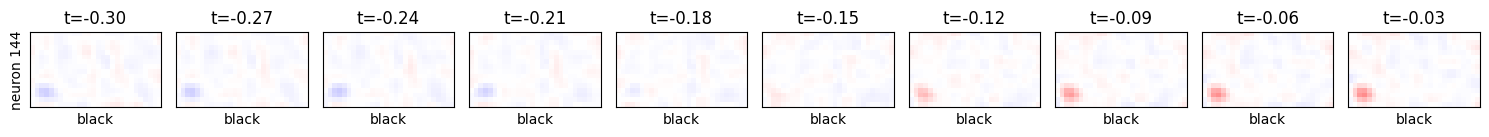

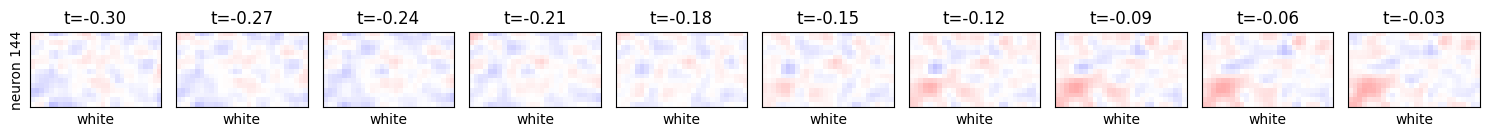

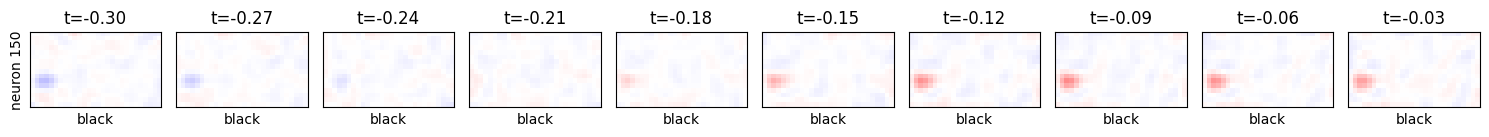

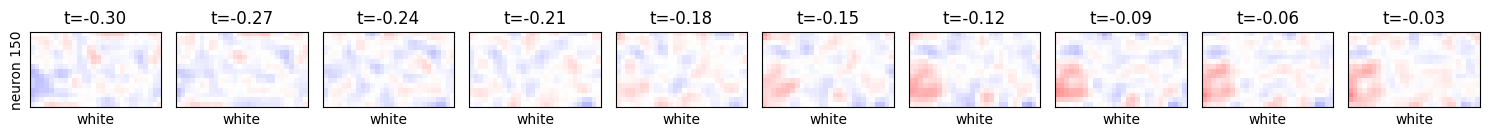

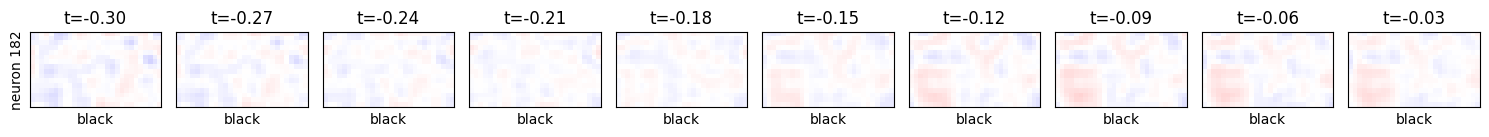

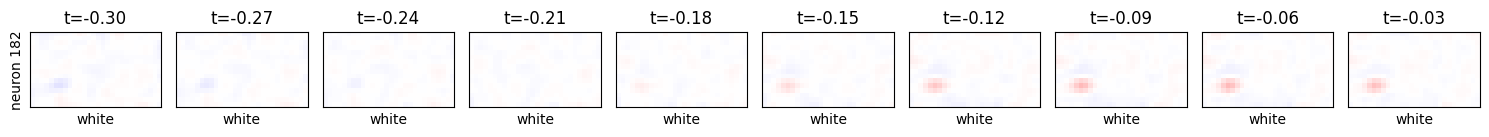

In [76]:
for cell_id in df["cell_ID"].unique():
    if not (cell_id in [*idx_black[0], *idx_white[0]]):
        continue
    
    for j, rfs in enumerate([z_score_black, z_score_white]):

        vmax = np.max([np.abs(rfs[cell_id].min()), rfs[cell_id].max()])

        fig, ax = plt.subplots(1, 10, figsize=(15, 3))
        for i in range(10):
            ax[i].imshow(
                gaussian_filter(rfs[cell_id][i], 1),
                cmap=plt.cm.bwr,
                vmin=-vmax,
                vmax=vmax,
            )
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_title(f"t={tt[i]:.02f}")
            ax[i].set_xlabel(["black", "white"][j % 2])
            if i == 0:
                ax[i].set_ylabel(f"neuron {cell_id}")
        fig.tight_layout()
        plt.show()